### Tutorial of spatial imputation on slice #151673 of DLPFC using CPS

In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import pandas as pd
import CPS

In [3]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2026'])
args.prep_scale = False
args.sigma=0.8
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/1-DLPFC/'
CPS.set_random_seed(args.seed)
args

Namespace(batch_size=256, clusters=7, coord_dim=2, dataset_path='/mnt/d/Dataset/SRT_Dataset/1-DLPFC/', decoder_latent=[256, 512, 1024], distill=1.0, dropout=0.2, er_w=0.05, flow='source_to_target', freq=32, gpu=0, hvgs=3000, inr_latent=[256, 256, 256], k_list=[0, 1, 2, 3, 4, 5, 6, 7], latent_dim=64, lr=0.001, max_epoch=1000, max_neighbors=6, n_spot=0, num_heads=4, prep_scale=False, radius=150, seed=2026, self_loops=True, sigma=0.8, weight_decay=0.0001)

In [4]:
section = '151673'
mask_ratio = 0.5
adata = sc.read_visium(os.path.join(args.dataset_path+section))
Ann_df = pd.read_csv(os.path.join(args.dataset_path+'1-DLPFC_annotations/', section+'_truth.txt'), 
                     sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
adata.var_names_make_unique()
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs, layer='counts')
adata_hvg = adata[:, adata.var['highly_variable']].copy()
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)
sc.pp.scale(adata_hvg, max_value=10)

counts_layer = adata_hvg.layers['counts']
adata_hvg.obsm['hvg_features'] = adata_hvg.X
adata_hvg.obsm['hvg_counts'] = counts_layer.toarray()

In [6]:
spatial_data = CPS.SpatialGraphBuilder(args)
train_data, test_data, train_indices, _ = spatial_data.spots_perturb(adata_hvg, mask_ratio=mask_ratio)
print(train_data)

Data(x=[1820, 3000], edge_index=[2, 15318], y=[1820, 3000], pos=[1820, 2], num_nodes=1820, num_genes=3000)


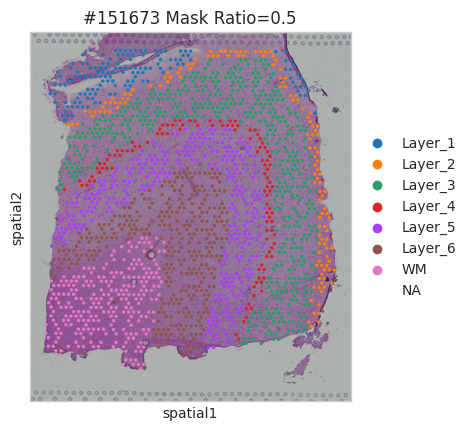

In [7]:
sc.pl.spatial(adata_hvg[train_indices], img_key="hires", 
              color=["Ground Truth"], 
              title=[f'#{section} Mask Ratio={mask_ratio}'])

In [8]:
cps_model = CPS.CPSTrainer(args)
cps_model.fit(train_data, print_every=100)

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch   0: Train[Total:2.7577, T:1.0400, S:0.9465, D:0.7712]

Epoch  10: Train[Total:1.3602, T:0.5581, S:0.5035, D:0.2986]

Epoch  20: Train[Total:1.2876, T:0.5443, S:0.4925, D:0.2509]

Epoch  30: Train[Total:1.2693, T:0.5391, S:0.4881, D:0.2421]

Epoch  40: Train[Total:1.2701, T:0.5354, S:0.4859, D:0.2488]

Epoch  50: Train[Total:1.2925, T:0.5261, S:0.4843, D:0.2821]

Epoch  60: Train[Total:1.3497, T:0.5099, S:0.4830, D:0.3568]

Epoch  70: Train[Total:1.4220, T:0.4811, S:0.4820, D:0.4588]

Epoch  80: Train[Total:1.4598, T:0.4802, S:0.4809, D:0.4987]

Epoch  90: Train[Total:1.4406, T:0.4786, S:0.4796, D:0.4824]

Epoch 100: Train[Total:1.4070, T:0.4774, S:0.4786, D:0.4510]

Epoch 110: Train[Total:1.3838, T:0.4763, S:0.4777, D:0.4298]

Epoch 120: Train[Total:1.3420, T:0.4755, S:0.4768, D:0.3897]

Epoch 130: Train[Total:1.3148, T:0.4748, S:0.4764, D:0.3637]

Epoch 140: Train[Total:1.2955, T:0.4739, S:0.4758, D:0.3457]

Epoch 150: Train[Total:1.2731, T:0.4733, S:0.4752, D:0.3246]

Epoch 1

Compute the metrics on test dataset

In [9]:
metrics = cps_model.evaluate_spots_imputation(test_data=test_data, experiment_name='DLPFC_SI', use_log1p=True)

Performing spots imputation, number of test spots: 1819

Computing metrics on **Log1p Transformed** data...

Spatial imputation metrics [Log1p Transformed]

[global flatten metrics]
MSE:           0.061174
RMSE:          0.247333
MAE:           0.133528
R²:            0.642228
Pearson:       0.806507
Spearman:      0.498330

[sample mean metrics]
CS:               0.799225
CS nonzero:       0.895830
Pearson:          0.771611
Pearson nonzero:  0.776410
Spearman:         0.482956
Spearman nonzero: 0.639588
SAM:              36.519253°
SAM nonzero:      26.384718°
MSE:              0.061174
MSE nonzero:      0.267184
MAE:              0.133529
MAE nonzero:      0.445867

 num of sample: 1819.0
Metrics saved to: ./results/DLPFC_SI_metrics.json


### Analysis of the imputed gene expression

In [10]:
# mask_ratio=0 to get all the inference data
train_data, _, _, _ = spatial_data.spots_perturb(adata_hvg, mask_ratio=0.)
imputed_expr, z_s = cps_model.infer_postion(train_data)
imputed_expr.shape

torch.Size([3639, 3000])

In [11]:
adata_hvg.layers['imputed'] = imputed_expr.detach().cpu().numpy()
adata_hvg.obsm['z_s'] = z_s.detach().cpu().numpy()
adata_hvg

AnnData object with n_obs × n_vars = 3639 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'hvg_features', 'hvg_counts', 'z_s'
    layers: 'counts', 'imputed'

In [12]:
import numpy as np
adata_hvg.layers['log1p_raw'] = np.log1p(adata_hvg.layers['counts']) 
adata_hvg.layers['log1p_imputed'] = np.log1p(adata_hvg.layers['imputed'])

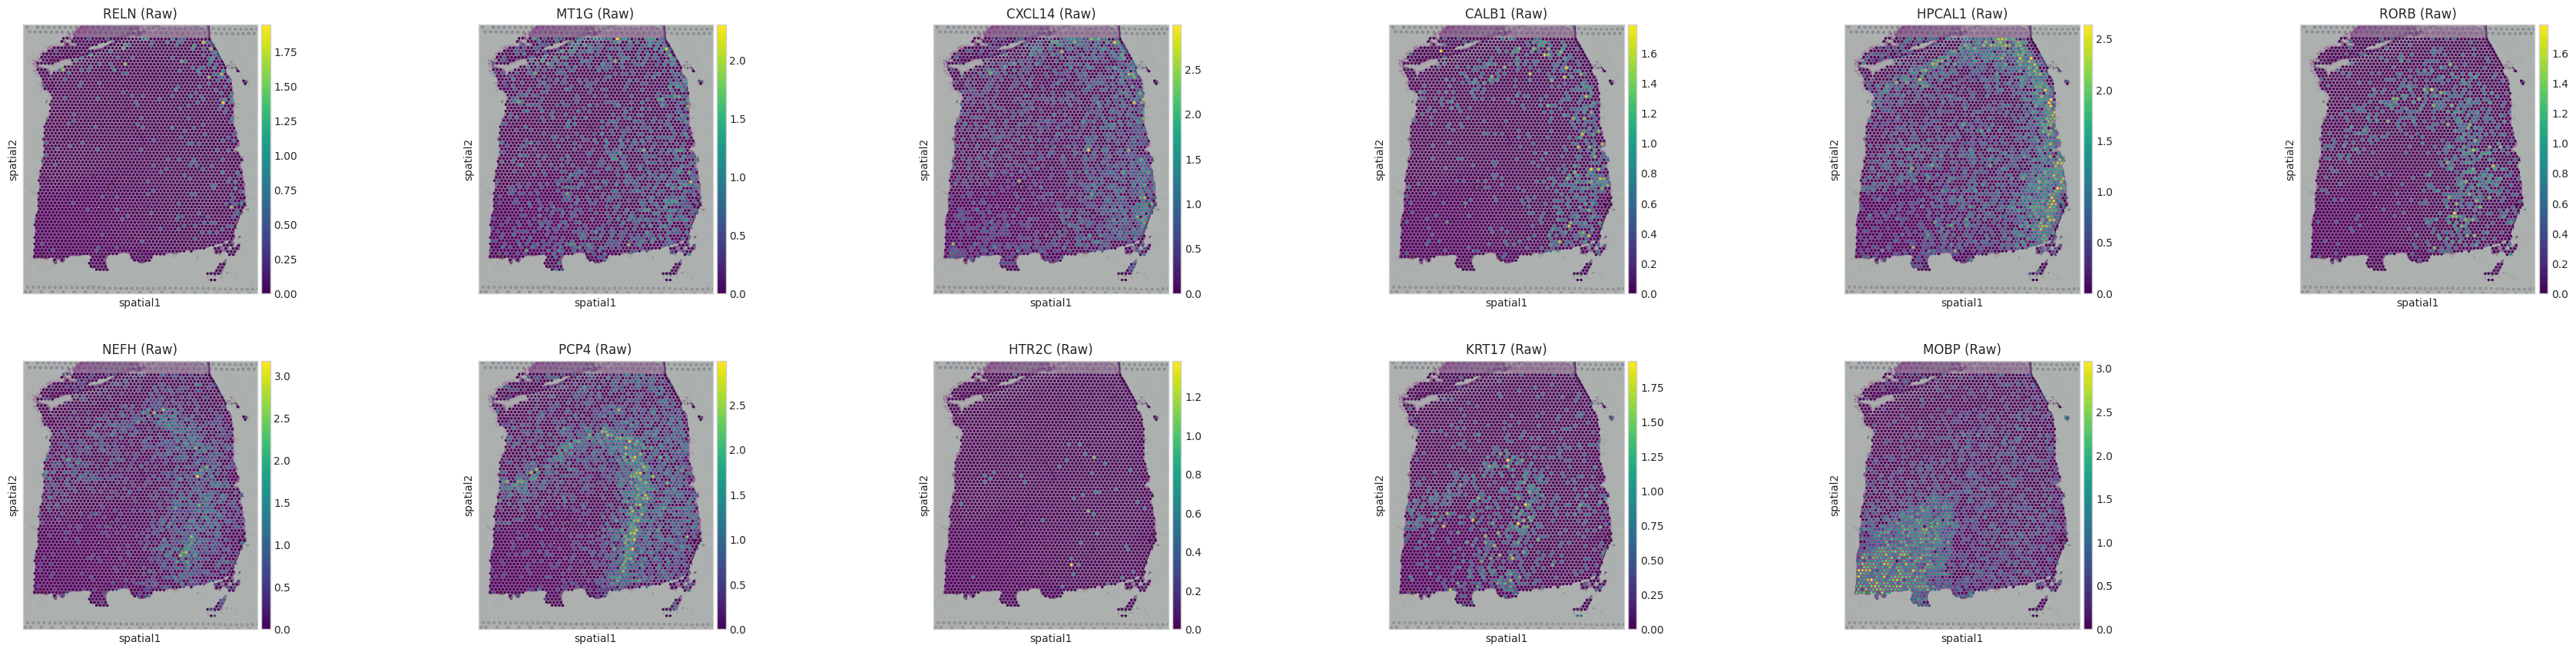

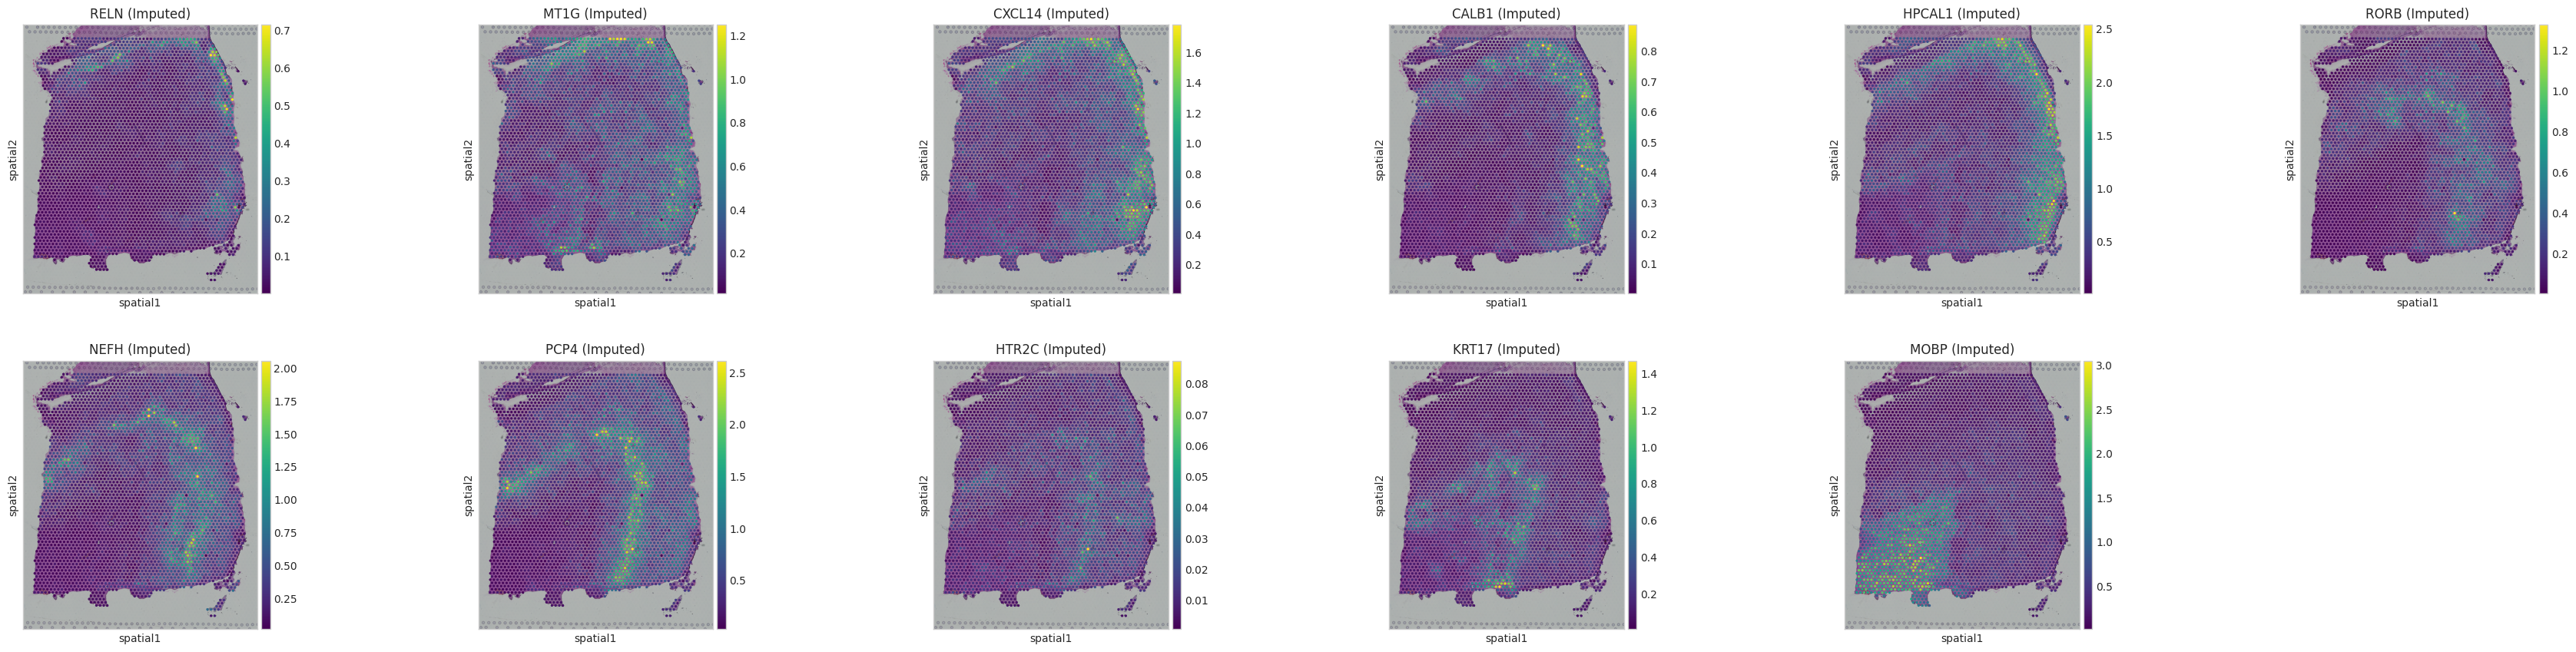

In [13]:
genes_to_plot = [
    'RELN',    # Layer 1
    'MT1G',    # Layer 1
    'CXCL14',  # Layer 2
    'CALB1',   # Layer 2
    'HPCAL1',  # Layer 2/3
    'RORB',    # Layer 4 
    'NEFH',    # Layer 4
    'PCP4',    # Layer 5 
    'HTR2C',   # Layer 5
    'KRT17',   # Layer 6
    'MOBP'     # White Matter
]

sc.pl.spatial(adata_hvg, cmap='viridis',
              color=genes_to_plot, layer='log1p_raw', 
              title=[f"{g} (Raw)" for g in genes_to_plot], ncols=6)
sc.pl.spatial(adata_hvg, cmap='viridis',
              color=genes_to_plot, layer='log1p_imputed',
              title=[f"{g} (Imputed)" for g in genes_to_plot], ncols=6)

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

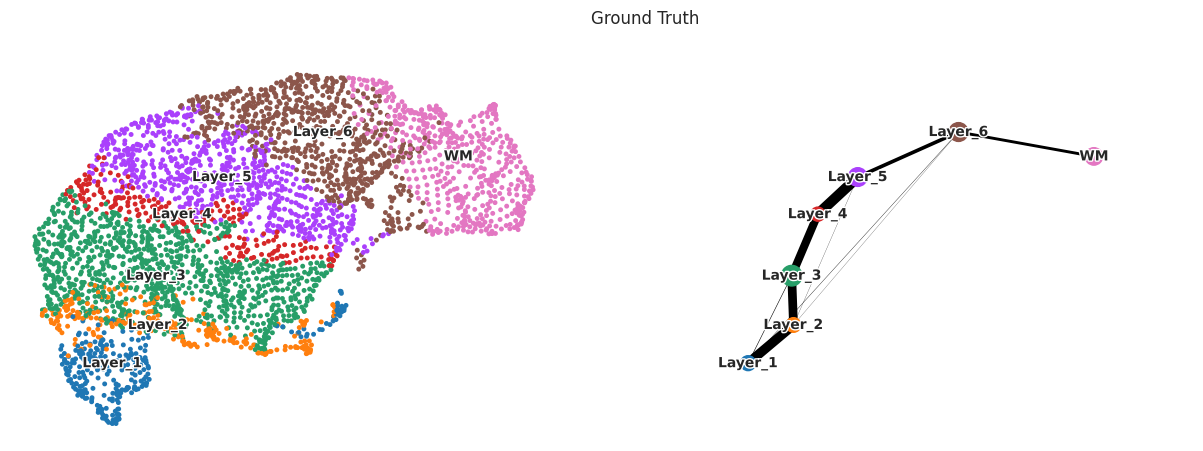

In [14]:
sc.pp.neighbors(adata_hvg, use_rep='z_s')
sc.tl.umap(adata_hvg)
adata_hvg = adata_hvg[adata_hvg.obs['Ground Truth'].notna(),:]
sc.tl.paga(adata_hvg, groups='Ground Truth')
sc.pl.paga_compare(adata_hvg, frameon=False, size=50, 
                   legend_fontoutline=2, show=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


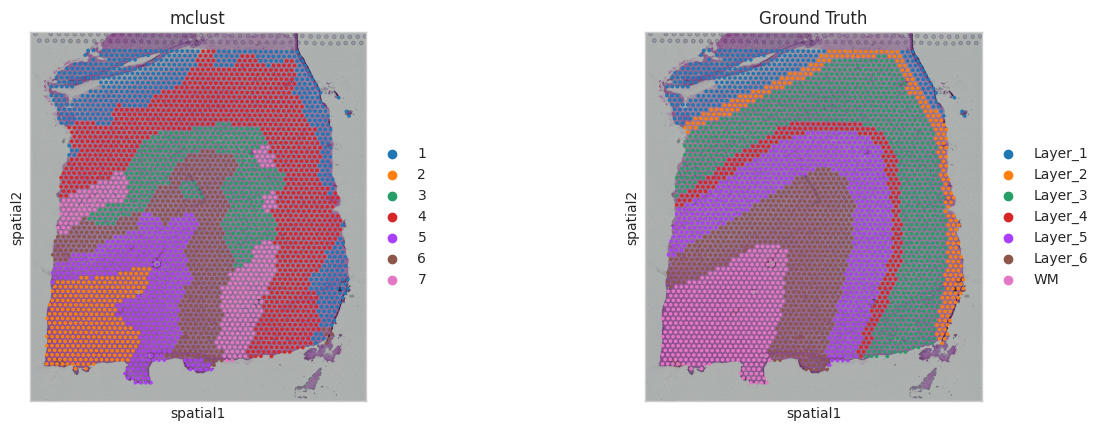

[<Axes: title={'center': 'mclust'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Ground Truth'}, xlabel='UMAP1', ylabel='UMAP2'>]

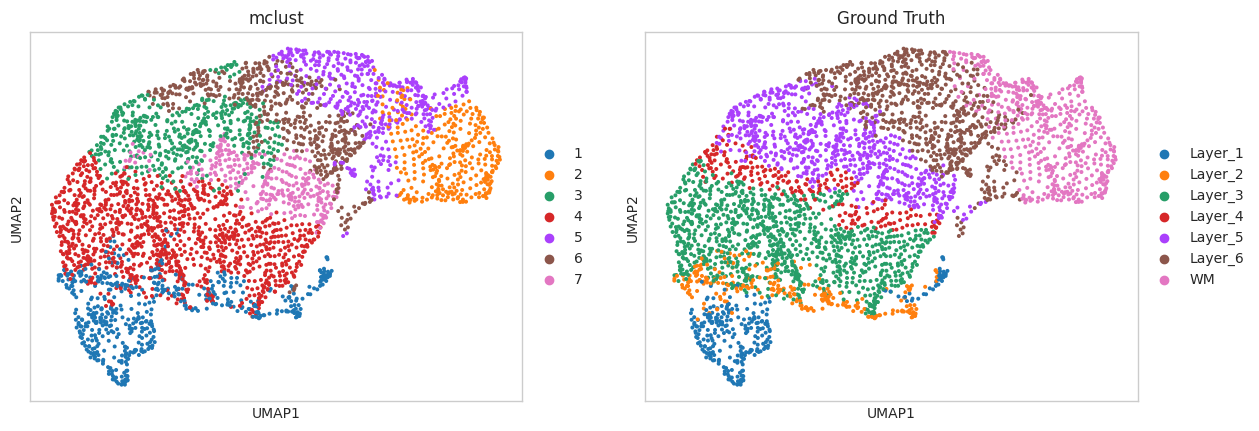

In [15]:
adata_hvg = CPS.mclust(adata_hvg, args, key='z_s', pca_dim=32, refine=True)
sc.pl.spatial(adata_hvg, img_key="hires", color=["mclust",'Ground Truth'])
sc.pl.embedding(adata_hvg, basis='umap', color=["mclust", "Ground Truth"], show=False)